# Задача на CTF от компании QRate
**Категории**: криптография, стеганография

**Материалы**: картинка vernam.jpeg (разрешение:800x800, вес: 55МБ)

**Текст задачи**: Вам досталась редкая диковинка: портрет Гильберта Вернама, известного криптографа. Сможете ли вы разгадать его секрет?

## Введение

Так как QRate - это компания, которая занимается квантовой криптографией, мы хотели включить в задачу что-то связанное с нашей работой.

Основная цель криптографии - это безопасная коммуникация, содержание которой остается в секрете. Для этого криптографы используют различные шифры и алгоритмы. Безопасность в них гарантируется сложностью и необычностью математики, используемой для шифрования.

Квантовая криптография в противовес этому фокусируется не на самих шифрах, но на ключах, которые в них используются. Есть ряд довольно простых шифров, гарантирующих абсолютную невозможность взлома (даже с точки зрения теории). Единственное условие - наличие у Алисы и Боба одинакового истинно случайного ключа, который будет использован в процессе. Именно этого мы и добиваемся.

Наиболее распространенный вариант такого шифрования - это шифр Вернама: ключ и сообщение складываются по модулю два сначала Алисой для шифровки, а затем Бобом для расшифровки. При этом, ключ может быть использован для шифрования только одной части сообщения одинаковой с ним длины. Именно нарушение этого правила делает возможной атаку, которую мы предлагаем участникам осуществить в нашей задаче.

Почему же нельзя использовать ключ несколько раз? Дело в том, что многократное повторное использование секретного ключа дает возможность сделать частотный анализ. Злоумышленник (Ева) всё еще не знает, как расшифровать те или иные зашифрованные символы, но он может посчитать их количество в потоке информации, после чего определить язык сообщения. Сопоставив гистограмму частоты символов языка с полученной, Ева может расшифровать часть символов, вычислить с их помощью ключ, и узнать содержание всего сообщения.

Поскольку созданная нами задача довольно сложна, в ней спрятаны дополнительные подсказки, которые могут ускорить и упростить решение.

Карта задачи выглядит следующим образом:

In [18]:
from ipywidgets import interact
from PIL import Image
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

In [19]:
initial_image = Image.open("vernam.jpeg")
initial_image_cropped = initial_image.crop((100, 625, 700, 775))
initial_image_cropped = initial_image_cropped.resize((900,300))

saturated_image = Image.open("vernam_saturated.png")
saturated_image_cropped = saturated_image.crop((100, 625, 700, 775))
saturated_image_cropped = saturated_image_cropped.resize((900,300))

saturated_blured_image = Image.open("vernam_saturated_blured.png")
saturated_blured_image_cropped = saturated_blured_image.crop((100, 625, 700, 775))
saturated_blured_image_cropped = saturated_blured_image_cropped.resize((900,300))

saturated_blured_image_cropped_array = np.array(saturated_blured_image_cropped)
saturated_blured_image_cropped_array_HSV = np.array(saturated_blured_image_cropped.convert("HSV"))

@interact(saturation = (0.0, 1.0), mode = ['normal', 'isolate color'])
def saturate_image(saturation, mode):

    if(mode == 'normal'):
        resulting_image = Image.blend(initial_image_cropped, saturated_image_cropped, saturation)
        display(resulting_image)
        
    if(mode == 'isolate color'):
        lower_mask = saturated_blured_image_cropped_array_HSV [:,:,2] >= 0
        upper_mask = saturated_blured_image_cropped_array_HSV [:,:,2] <= 231
        mask = upper_mask * lower_mask
        red = saturated_blured_image_cropped_array[:,:,0]*mask
        green = saturated_blured_image_cropped_array[:,:,1]*mask
        blue = saturated_blured_image_cropped_array[:,:,2]*mask
        isolated_mask = Image.fromarray(np.dstack((red,green,blue)))
        resulting_image_masked = Image.blend(initial_image_cropped, isolated_mask, saturation/1.3)
        display(resulting_image_masked)

interactive(children=(FloatSlider(value=0.5, description='saturation', max=1.0), Dropdown(description='mode', …

In [20]:
key = 'mctf{try_using_QRNG}'

def string_to_binary_utf8(message):
    return ''.join('0' + format(ord(letter), 'b') for letter in message)

def binary_utf8_to_string(message):
    return ''.join(chr(int(eightbits, 2)) for eightbits in [message[window:window + 8] for window in range(0, len(message), 8)])

def binary_utf8_to_binary_pixels(message):
    numbers = [['0110', '1001', '1001', '1001', '0110'], ['0010', '0110', '0010', '0010', '0111']]
    return ''.join(list((numbers[message[counter%8] == '1'][counter//8] for counter in range (40))))

def string_to_binary_pixels(message):
    return ''.join(binary_utf8_to_binary_pixels(string_to_binary_utf8(x)) for x in message)

Counter({' ': 45220, 'e': 27095, 't': 21606, 'o': 16918, 'a': 15831, 'n': 15572, 'i': 15560, 's': 14499, 'r': 11198, 'h': 10946, 'l': 9482, 'c': 7966, 'u': 6433, 'd': 6091, 'm': 5411, 'p': 4811, 'y': 4197, 'f': 4054, 'w': 3450, 'b': 3404, 'g': 3053, ',': 2700, '.': 2100, 'v': 1865, 'x': 901, '\n': 890, 'k': 889, 'B': 809, "'": 698, 'A': 626, 'q': 606, 'T': 517, 'I': 511, 'j': 265, 'W': 185, '-': 178, 'S': 177, '1': 177, '?': 164, ')': 162, '(': 158, '0': 153, 'E': 144, 'N': 142, 'C': 128, 'H': 116, 'F': 114, '=': 108, 'P': 96, 'O': 91, '3': 88, ':': 84, '4': 84, '9': 75, '!': 67, 'L': 64, '"': 55, 'R': 54, '2': 54, 'M': 48, 'G': 47, 'D': 47, 'z': 37, 'Q': 37, 'U': 36, '5': 31, '8': 28, 'J': 24, '+': 21, '7': 20, '*': 18, '/': 17, '|': 17, '6': 16, '_': 15, 'Y': 10, '\t': 7, 'V': 6, '[': 6, ']': 6, '%': 4, 'K': 3, '^': 2, 'Z': 2, '<': 1})


C:\Users\timof\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:134: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


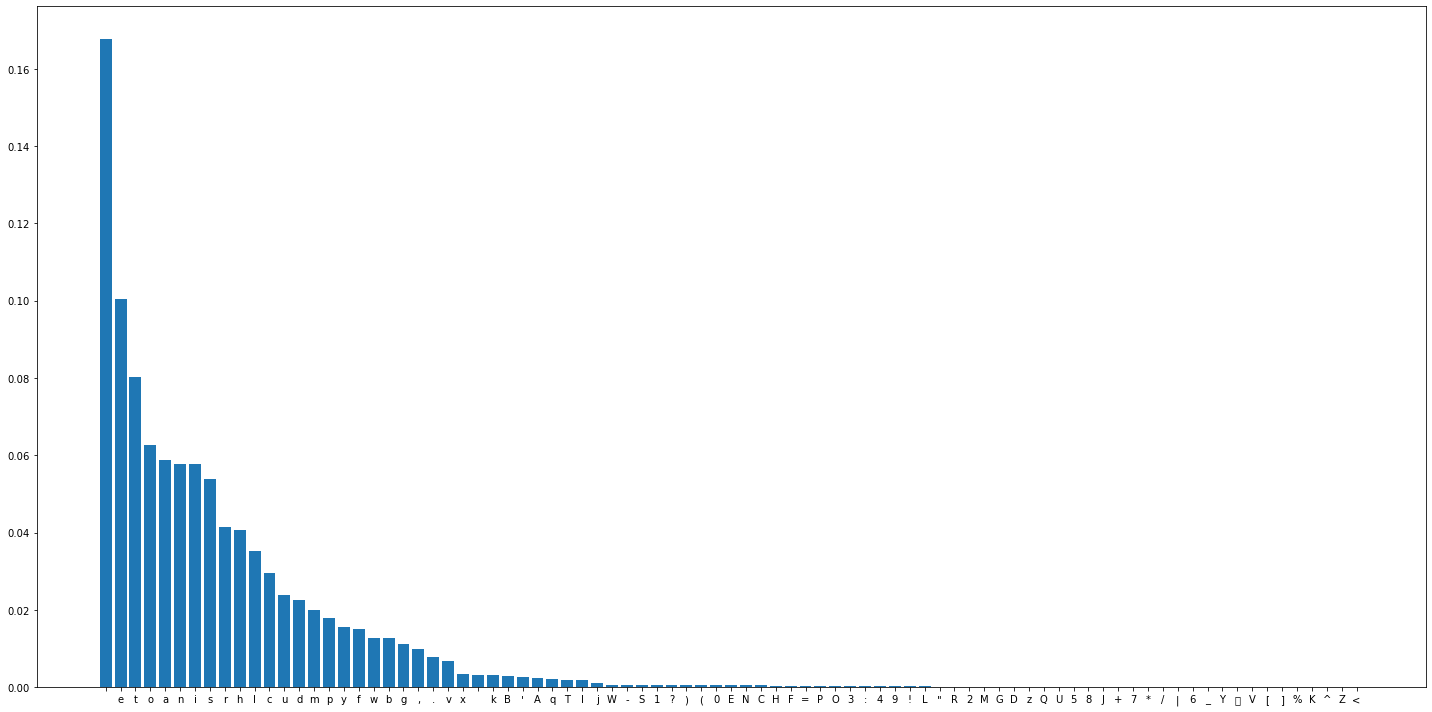

In [21]:
f = open("quantum_chance_eng.txt", "r")
#w = open("new_file.txt", "w")
#w.write(binary_utf8_to_string(f.read()))
#print(binary_utf8_to_string(f.read()))
text = f.read()
print(Counter(text))

plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
d = Counter(text)
d_filtered = d.most_common()
a = list((x[0] for x in d_filtered))
b = list((x[1]/sum(list(x[1] for x in d_filtered)) for x in d_filtered))
plt.bar(a, b)
plt.show()

In [64]:
letter_frequency_english_raw  = {'e': 12.7, 't': 9.06, 'a': 8.17, 'o': 7.51, 'i': 6.97, 'n': 6.75, 's': 6.33, 'h': 6.09,
                    'r': 5.99, 'd': 4.25, 'l': 4.03, 'c': 2.78, 'u': 2.76, 'm': 2.41, 'w': 2.36, 'f': 2.23,
                    'g': 2.02, 'y': 1.97, 'p': 1.93, 'b': 1.29, 'v': 0.98, 'k': 0.77, 'j': 0.15, 'x': 0.15,
                    'q': 0.10, 'z': 0.07}

letter_frequency_french_raw = {'e': 17.3, 'p': 3.0, 'a': 8.4, 'g': 1.3, 's': 8.1, 'v': 1.3, 'i': 7.3, 'b': 1.1, 'n': 7.1,
                    'f': 1.1, 't': 7.1, 'q': 1.0, 'r': 6.6, 'h': 0.9, 'l': 6.0, 'x': 0.4, 'u': 5.7, 'j': 0.3,
                    'o': 5.3, 'y': 0.3, 'd': 4.2, 'k': 0.1, 'c': 3.0, 'w': 0.1, 'm': 3.0, 'z': 0.1}

letter_frequency_german_raw = {'e': 16.93, 'n': 10.53, 'i': 8.02, 'r': 6.89, 's': 6.42, 't': 5.79, 'a': 6.12, 'd': 4.98,
                    'h': 4.98, 'u': 4.48, 'l': 3.60, 'c': 3.16, 'g': 3.02, 'm': 2.55, 'o': 2.54, 'b': 2.33, 'w': 1.78,
                    'f': 1.49, 'k': 1.32, 'z': 1.21, 'v': 0.84, 'p': 0.67, 'j': 0.24, 'x': 0.05, 'y': 0.05, 'q': 0.02}


letter_frequency_italian_raw = {'e': 11.97, 't': 6.97, 'a': 11.00, 'o': 10.08, 'i': 10.27, 'n': 7.02, 's': 5.48, 'h': 1.43,
                                'r': 6.19, 'd': 3.39, 'l': 5.70, 'c': 4.30, 'u': 3.28, 'm': 2.87, 'w': 2.36, 'f': 1.01,
                                'g': 1.65, 'y': 1.97, 'p': 2.96, 'b': 1.05, 'v': 1.75, 'k': 0.77, 'j': 0.15, 'x': 0.15,
                                'q': 0.45, 'z': 0.85}

def is_letter(letter):
    return (ord(letter) >= ord('a')) & (ord(letter) <= ord('z'))

@interact(language = ['english', 'french', 'german', 'italian'])
def compare_frequencies_graph(language):
    languages = {'english': letter_frequency_english_raw, 'french': letter_frequency_french_raw, 'german': letter_frequency_german_raw, 'italian': letter_frequency_italian_raw}
    language_frequencies = dict(sorted(languages[language].items(), key=lambda item: item[1],  reverse=True))
    a2 = list(language_frequencies.keys())
    b2 = list(d[x]/sum(list(d[x] for x in a2)) for x in a2)
    c2 = list(language_frequencies[x]/sum(list(language_frequencies[x] for x in a2)) for x in a2)

    error = sum((c2[x]-b2[x])**2 for x in range(len(language_frequencies)))

    X_axis = np.arange(len(a2))
    plt.bar(X_axis - 0.2, c2, 0.4)
    plt.bar(X_axis + 0.2, b2, 0.4)
    plt.xticks(X_axis, a2)
    plt.show()

    print('error: ' + str(error))

interactive(children=(Dropdown(description='language', options=('english', 'french', 'german', 'italian'), val…